# Question Answering System Classification Part (BERT)


## Importing the necessary packages and libraries

In [ ]:
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
## for processing
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import string

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for w2v
import gensim
import gensim.downloader as gensim_api
## for bert
!pip install transformers
import transformers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Using the gensim api in order to create "clusters" of words that we are going to use instead of any training data

In [ ]:
nlp1 = gensim_api.load("glove-wiki-gigaword-300")

In [ ]:
## Function to apply
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

n=25

## Create Dictionary {category:[keywords]}
dic_clusters = {}
dic_clusters["PLACE"] = get_similar_words(['village','place','history','myth'], top=n, nlp=nlp1)
dic_clusters["BEACH"] = get_similar_words(['beach','sand','water','sea','swim'], top=n, nlp=nlp1)
dic_clusters["ACTIVITY"] = get_similar_words(['activity','festival','riding','tour'], top=n, nlp=nlp1)
dic_clusters["TOURIST_ATTRACTION"] = get_similar_words(['attraction','ancient','castle','museum','church','volcano'], top=n, nlp=nlp1)
dic_clusters["LOCAL_FOOD_DRINK"] = get_similar_words(['food','drink','cuisine','vegetables','wine','eat','traditional'], top=n, nlp=nlp1)
dic_clusters["NOTABLE_PERSON"] = get_similar_words(['person','name','notable','born','died'], top=n, nlp=nlp1)
dic_clusters["CLIMATE"] = get_similar_words(['climate','weather','rain','temperature','month'], top=n, nlp=nlp1)
dic_clusters["HEALTHCARE"] = get_similar_words(['hospital','medical','healthcare','emergency','doctor',], top=n, nlp=nlp1)
dic_clusters["INFORMATION"] = get_similar_words(['atm','rent','information','useful','driving','knowledge'], top=n, nlp=nlp1)

## print some
for k,v in dic_clusters.items():
    print(k, ": ", v[0:len(v)], "...", len(v))



PLACE :  ['what', 'culture', 'this', 'place', 'myth', 'fact', 'of', 'which', 'just', 'there', 'historical', 'in', 'life', 'modern', 'history', 'the', 'where', 'part', 'tradition', 'town', 'one', 'village', 'century', 'time', 'ancient', 'is', 'it', 'same', '.'] ... 29
BEACH :  ['inland', 'sea', 'fish', 'water', 'surf', 'along', 'lagoon', 'pond', 'mud', 'swimming', 'waters', 'boat', 'coastal', 'shallow', 'shores', 'shoreline', 'beach', 'swim', 'shore', 'boats', 'washed', 'river', 'surface', 'seas', 'beaches', 'fishing', 'lake', 'coral', 'sand', 'ocean'] ... 30
ACTIVITY :  ['walking', 'concert', 'riding', 'this', 'ride', 'rides', 'trip', 'coming', 'cycling', 'activities', 'events', 'bike', '.', 'event', 'day', 'festival', 'weekend', 'year', 'traveling', 'part', 'activity', 'festivals', 'trips', 'summer', 'tours', 'tour', 'same', 'during', 'touring'] ... 29
TOURIST_ATTRACTION :  ['monument', 'church', 'famous', 'historical', 'attractions', 'temple', 'cathedral', 'monastery', 'historic', 'n

In [ ]:
#Removing Punctuation, Null entries and stopwords

def Cleaning_1_1(dic_clusters):

  lst_stopwords = nltk.corpus.stopwords.words("english")

  for k,v in dic_clusters.items():
    for word in v:
      if len(word)<=2:
        v.remove(word)

    for i in lst_stopwords:
      if i in v:
        v.remove(i)

    new_list = v
    dic_clusters.update({k: list(filter(None, new_list))})

  return dic_clusters

In [ ]:
#Removing duplicates between the dictionaries

def Cleaning_1_2(dic_clusters):
  seen = set()
  repeated = set()
  new_list=[]

  for k,v in dic_clusters.items():
    for i in set(v):
      if i in seen:
        repeated.add(i)
      else:
        seen.add(i) 
    
  for i in repeated:
    x=0
    for k,v in dic_clusters.items():
      new_list2 = v
      if i in v:
        x=x+1
        if x>1:
          new_list2.remove(i)
     
      dic_clusters.update({k: new_list2})


# Πειραμα 1.1

In [ ]:

Cleaning_1_1(dic_clusters)

for k,v in dic_clusters.items():
    print(k, ": ", v[0:len(v)], "...", len(v))


PLACE :  ['culture', 'place', 'myth', 'fact', 'historical', 'life', 'modern', 'history', 'part', 'tradition', 'town', 'one', 'village', 'century', 'time', 'ancient'] ... 16
BEACH :  ['inland', 'sea', 'fish', 'water', 'surf', 'along', 'lagoon', 'pond', 'mud', 'swimming', 'waters', 'boat', 'coastal', 'shallow', 'shores', 'shoreline', 'beach', 'swim', 'shore', 'boats', 'washed', 'river', 'surface', 'seas', 'beaches', 'fishing', 'lake', 'coral', 'sand', 'ocean'] ... 30
ACTIVITY :  ['walking', 'concert', 'riding', 'ride', 'rides', 'trip', 'coming', 'cycling', 'activities', 'events', 'bike', 'event', 'day', 'festival', 'weekend', 'year', 'traveling', 'part', 'activity', 'festivals', 'trips', 'summer', 'tours', 'tour', 'touring'] ... 25
TOURIST_ATTRACTION :  ['monument', 'church', 'famous', 'historical', 'attractions', 'temple', 'cathedral', 'monastery', 'historic', 'near', 'site', 'built', 'volcano', 'ruins', 'castle', 'museum', 'situated', 'archaeological', 'town', 'village', 'nearby', 'cen

# Πειραμα 1.2

In [ ]:

Cleaning_1_2(dic_clusters)

for k,v in dic_clusters.items():
    print(k, ": ", v[0:len(v)], "...", len(v))


PLACE :  ['culture', 'place', 'myth', 'fact', 'historical', 'life', 'modern', 'history', 'part', 'tradition', 'town', 'one', 'village', 'century', 'time', 'ancient'] ... 16
BEACH :  ['inland', 'sea', 'fish', 'water', 'surf', 'along', 'lagoon', 'pond', 'mud', 'swimming', 'waters', 'boat', 'coastal', 'shallow', 'shores', 'shoreline', 'beach', 'swim', 'shore', 'boats', 'washed', 'river', 'surface', 'seas', 'beaches', 'fishing', 'lake', 'coral', 'sand', 'ocean'] ... 30
ACTIVITY :  ['walking', 'concert', 'riding', 'ride', 'rides', 'trip', 'coming', 'cycling', 'activities', 'events', 'bike', 'event', 'day', 'festival', 'weekend', 'year', 'traveling', 'activity', 'festivals', 'trips', 'summer', 'tours', 'tour', 'touring'] ... 24
TOURIST_ATTRACTION :  ['monument', 'church', 'famous', 'attractions', 'temple', 'cathedral', 'monastery', 'historic', 'near', 'site', 'built', 'volcano', 'ruins', 'castle', 'museum', 'situated', 'archaeological', 'nearby', 'palace', 'attraction', 'medieval', 'heritage

LOADING AND PREPROCESSING THE TEST SET

In [ ]:
#preprocessing and cleaning method

'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
dtf = pd.read_csv("Question_Classification_TestSet.csv")
dtf.head()

lst_stopwords = nltk.corpus.stopwords.words("english")
#print(lst_stopwords)

dtf["text_clean"] = dtf["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()

,text,label,text_clean
0,Are there any quiet beaches in Akrotiri?,BEACH,quiet beach akrotiri
1,Fun things to do in Santorini for couples,ACTIVITY,fun thing santorini couple
2,Traditional food to try in Santorini,LOCAL_FOOD_DRINK,traditional food try santorini
3,Average weather in July,CLIMATE,average weather july
4,"I want to go for a boat tour, can I?",ACTIVITY,want go boat tour


LOADING BERT

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
## function to apply
def utils_bert_embedding(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    X = np.array(embedding[0][0][1:-1])
    return X


## create list of news vector
lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) 
                 for txt in dtf["text_clean"]]
## create the feature matrix (n news x 768)
X = np.array(lst_mean_vecs)

#print(X)
#print(lst_mean_vecs)

In [ ]:
dic_y = {k:utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v
         in dic_clusters.items()}


#for y in dic_y.values():
  #print(y.shape)
  #print(y)
  #print("TO RESHAPED", y.reshape(1, -1).shape)


In [ ]:
#--- Model Algorithm ---#
## compute cosine similarities
similarities = np.array(
            [metrics.pairwise.cosine_similarity(lst_mean_vecs, y.reshape(1, -1)).T.tolist()[0] 
             for y in dic_y.values()]
            ).T
#print(similarities)     

## adjust and rescale
labels = list(dic_y.keys())
for i in range(len(similarities)):
    ### assign randomly if there is no similarity
    if sum(similarities[i]) == 0:
       similarities[i] = [0]*len(labels)
       similarities[i][np.random.choice(range(len(labels)))] = 1
    ### rescale so they sum = 1
    similarities[i] = similarities[i] / sum(similarities[i])

## classify the label with highest similarity score
predicted_prob = similarities
predicted = [labels[np.argmax(pred)] for pred in predicted_prob]

print(predicted)

['PLACE', 'PLACE', 'LOCAL_FOOD_DRINK', 'CLIMATE', 'ACTIVITY', 'ACTIVITY', 'TOURIST_ATTRACTION', 'TOURIST_ATTRACTION', 'PLACE', 'NOTABLE_PERSON', 'PLACE', 'TOURIST_ATTRACTION', 'INFORMATION', 'INFORMATION', 'ACTIVITY', 'CLIMATE', 'PLACE', 'PLACE', 'BEACH', 'CLIMATE', 'ACTIVITY', 'LOCAL_FOOD_DRINK', 'BEACH', 'NOTABLE_PERSON', 'PLACE', 'CLIMATE', 'INFORMATION', 'ACTIVITY', 'HEALTHCARE', 'TOURIST_ATTRACTION', 'PLACE', 'INFORMATION']


Accuracy: 0.75
Auc: 0.51
Detail:
                    precision    recall  f1-score   support

          ACTIVITY       0.60      0.75      0.67         4
             BEACH       0.50      0.33      0.40         3
           CLIMATE       1.00      1.00      1.00         4
        HEALTHCARE       1.00      0.33      0.50         3
       INFORMATION       0.75      0.75      0.75         4
  LOCAL_FOOD_DRINK       1.00      0.67      0.80         3
    NOTABLE_PERSON       1.00      0.67      0.80         3
             PLACE       0.62      1.00      0.77         5
TOURIST_ATTRACTION       0.75      1.00      0.86         3

          accuracy                           0.75        32
         macro avg       0.80      0.72      0.73        32
      weighted avg       0.79      0.75      0.74        32



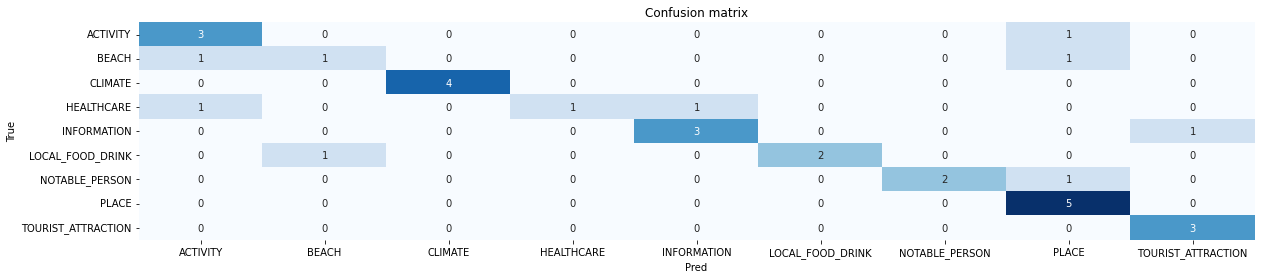

In [ ]:
y_test = dtf["label"].values
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values


## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))



## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
fig.set_figwidth(20)